# Building the learning database


In [14]:
import datetime
import glob
import pickle
import os
import pathlib
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from skimage.feature import hog
from skimage.color import rgb2grey
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from PIL import Image

In [22]:
with open('parameters.yaml') as yaml_data:
    params = yaml.safe_load(yaml_data)
    
TRAINING_CSV_PATH = params['paths']['training_images']
TEST_IMAGES_PATH = params['paths']['test_images']
TEST_GT = params['paths']['test_GT']
save_model_path = params['paths']['save_model_path']
load_model_path = params['paths']['load_model_path']

IMAGE_WIDTH = params['parameters']['IMAGE_WIDTH']
IMAGE_HEIGHT = params['parameters']['IMAGE_HEIGHT']

In [6]:
os.path.dirname(TRAINING_CSV_PATH)

'../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*'

In [7]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)



def build_images_list(filename_list, boxes_list=None):
    """Build a list of images as Numpy array
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    
    Returns
    -------
    A list of images as Numpy arrays
    
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    images_list = []
    for (filename, image_box) in zip(filename_list, boxes_list):
        image = Image.open(filename)
        
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
        
        image = np.array(image)
        
        image_color = image.flatten()
        
        # convert images to greyscale
        image =rgb2grey(image)
        
        # get HOG features from greyscale image
        hog_features = hog(image, block_norm='L2-Hys', pixels_per_cell=(2, 2)) 
        
        # combine color and hog features into a single array
        flat_features = np.hstack(image_color)
        images_list.append(flat_features)
        
    return images_list



def save_classifier(model, basename):
    """Save to pickle format a SVM model 

    Paramaters
    ----------
    model: trained SVM model
    basename: basename including path to use for filename

    Returns
    -------
    None
    """
    pickle.dump(model, open(basename, 'wb'))
 
    return


def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values



def classify_image(path, model, image_box=None):
    """Classify image by model
    
    Parameters
    ----------
    path: filepath to image
    model: SVM classifier
    
    Returns
    -------
    class id returned by model classifier
    """
    images_list = []
    image = Image.open(path)
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
    image = np.array(image)
    image_color = image.flatten()
        
    # convert images to greyscale
    image =rgb2grey(image)
        
    # get HOG features from greyscale image
    hog_features = hog(image, block_norm='L2-Hys', pixels_per_cell=(2, 2)) 
        
    # combine color and hog features into a single array
    flat_features = np.hstack(image_color)
    images_list.append(flat_features)

    return model.predict(np.array(images_list))

In [8]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
1,00000_00001.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
2,00000_00002.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
3,00000_00003.ppm,31,31,5,5,26,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
4,00000_00004.ppm,30,32,5,6,25,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...


In [9]:
N = 1 #Test the code on a sample of 1 image
N = None #Take all

if N is None:
    images_list = build_images_list(images_df.head(N)['path'].values,
                                images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)
    data = np.array(images_list)
    labels = build_classes_array(images_df)
else:
    images_list = build_images_list(images_df.head(N)['path'].values,
                                images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)
    data = np.array(images_list)
    labels = build_classes_array(images_df)[:N]

print(data.shape, labels.shape)

<ipython-input-7-e3372fc830f2>:54: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.
  image =rgb2grey(image)


(39209, 2700) (39209,)


In [10]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 2700) (7842, 2700) (31367,) (7842,)


# Training the model

In [19]:
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)
Runtime of the program is 2053.6776361465454


# Saving and loading the model 

In [ ]:
save_classifier(svm, save_model_path + "traffic_signs_svm.pickle")

In [13]:
svm_model = pickle.load(open(load_model_path + "_svm.pickle", 'rb'))

C:\Users\Elisa SEBASTIAN\anaconda3\envs\traffic\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Performance of the model

In [18]:
from sklearn.metrics import accuracy_score
# generate predictions
y_pred = svm_model.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(' SVM model accuracy is: ', accuracy)

 SVM model accuracy is:  0.9929864830400408


## Evaluating performance on the test set

### Classify images

In [20]:
image_sample = images_df.sample(50)

classify_image(image_sample['path'].values[0],
               svm_model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0])

<ipython-input-7-e3372fc830f2>:119: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.
  image =rgb2grey(image)


array([2], dtype=int64)

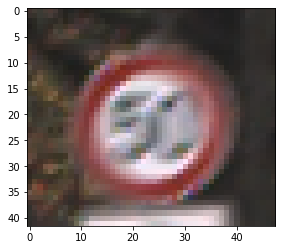

In [21]:
plt.imshow(Image.open(image_sample['path'].values[0]))

### Load test images

In [23]:
test_images_df = pd.read_csv(TEST_GT, sep=';')
test_images_df['path'] = test_images_df['Filename'].apply(lambda x: TEST_IMAGES_PATH + x)
test_images_df.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
12625,12625.ppm,42,41,5,6,37,36,12,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12626,12626.ppm,50,51,6,5,45,46,33,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12627,12627.ppm,29,29,6,6,24,24,6,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12628,12628.ppm,48,49,5,6,43,44,7,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12629,12629.ppm,32,31,6,5,27,26,10,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...


In [24]:
test_list = build_images_list(test_images_df['path'].values,
                                test_images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)
test_data = np.array(test_list)
test_labels = build_classes_array(test_images_df)

<ipython-input-7-e3372fc830f2>:54: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.
  image =rgb2grey(image)


In [25]:
results = svm_model.predict(test_data)

In [49]:
(test_labels == results).sum() / test_labels.shape[0]

0.875771971496437

In [27]:
test_data[0]

array([118, 138, 171, ..., 115, 138, 171], dtype=uint8)

### Compare actual to predicted (class level)

In [50]:
np.transpose(results)

array([16,  1, 38, ...,  5,  7, 10])

In [51]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results

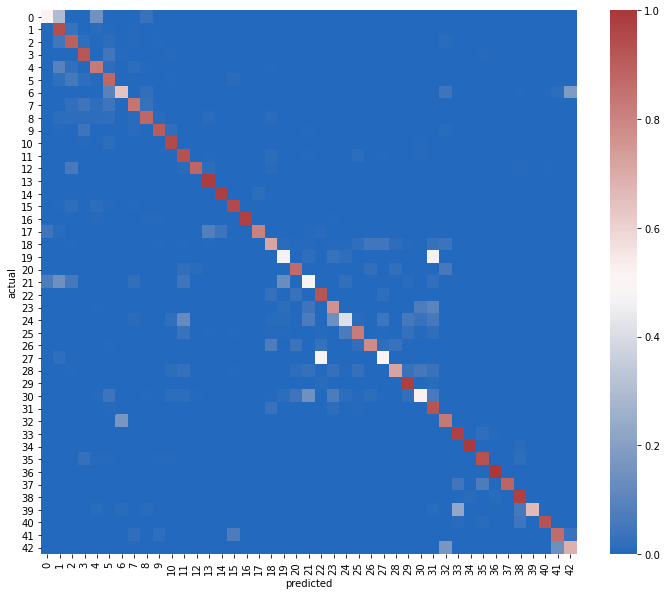

In [52]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'), cmap='vlag');

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89        35
           1       0.94      0.96      0.95       458
           2       0.94      0.96      0.95       450
           3       0.95      0.94      0.95       285
           4       0.98      0.96      0.97       405
           5       0.94      0.96      0.95       398
           6       0.98      1.00      0.99        85
           7       0.97      0.96      0.96       297
           8       0.99      0.96      0.98       248
           9       0.99      0.95      0.97       324
          10       1.00      0.98      0.99       416
          11       0.97      0.95      0.96       272
          12       1.00      0.97      0.99       415
          13       0.99      0.99      0.99       466
          14       0.99      0.99      0.99       139
          15       0.98      0.96      0.97       121
          16       0.99      1.00      0.99        85
          17       0.99    